# normal_model

## 数据加载

In [9]:
# ================== 1️⃣ 导入路径与函数 ==================
%run ../_init_path.py

import os
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import subgraph, add_self_loops

# === 导入模型结构 ===
from models import GraphContrastiveLearner, augment_graph, summarize_graph

# ===================== 基本设置 =====================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
graph_path = "/home/charles/HZU/Data_processed/my_CIL_V1/KAIST/less_class/pyg_data/time/graph_withmask.pt"
save_dir = "/home/charles/HZU/Industrial_Software_Testing/Industrial_Software_Testing/my_CIL_V1/GCL_pre_train/KAIST_normal_model/model_save/time_less_class"
os.makedirs(save_dir, exist_ok=True)

# ===================== 2️⃣ 加载 PyG 图数据 =====================
data = torch.load(graph_path)
summarize_graph(data)

# ========== ⭐ 对 data.x 做 Z-score 标准化 ==========
x_mean = data.x.mean(dim=0, keepdim=True)
x_std = data.x.std(dim=0, keepdim=True) + 1e-6
data.x = (data.x - x_mean) / x_std

print("🎯 已完成 data.x 标准化: mean≈0, std≈1")

# ===================== 3️⃣ 构造 batch 子图 =====================
batch_size = 12000
num_nodes = data.num_nodes

perm = torch.randperm(num_nodes)

batches = []
for i in range(0, num_nodes, batch_size):
    node_idx = perm[i:i + batch_size]

    # ---- 提取子图（必须 CPU）----
    sub_edge_index, _ = subgraph(
        node_idx,
        data.edge_index,
        relabel_nodes=True
    )

    sub_x = data.x[node_idx]

    # ---------- ⭐ 加入自环（Self-loops） ----------
    sub_edge_index, _ = add_self_loops(
        sub_edge_index, num_nodes=sub_x.size(0)
    )

    sub_data = Data(
        x=sub_x,
        edge_index=sub_edge_index
    )
    batches.append(sub_data)

print(f"📌 共划分 batch 子图数量：{len(batches)}")

loader = DataLoader(batches, batch_size=1, shuffle=True)

# ===================== 4️⃣ 初始化模型 =====================
in_dim = data.x.size(1)
hidden_dim = 256
out_dim = 256
proj_dim = 128
tau = 0.5

model = GraphContrastiveLearner(in_dim, hidden_dim, out_dim, proj_dim, tau).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)


✅ 已添加路径：/home/charles/HZU/Industrial_Software_Testing/Industrial_Software_Testing/my_CIL_V1/GCL_pre_train/KAIST_normal_model
✅ 已添加 my_lib：/home/charles/HZU/Industrial_Software_Testing/Industrial_Software_Testing/my_CIL_V1/GCL_pre_train/KAIST_normal_model/src

🧩 Graph Data Summary
📊 节点数量 (num_nodes): 12000
📈 节点特征维度 (num_features): 4
🔗 边数量 (num_edges): 240000
🔁 自环数量 (self-loops): 0
🎯 标签维度 (y_dim): torch.Size([12000])

🧾 Data对象包含字段: ['x', 'y', 'train_nolabel_mask', 'edge_index', 'val_mask', 'train_withlabel_mask', 'train_mask', 'test_mask']

🎯 已完成 data.x 标准化: mean≈0, std≈1


/tmp/ipykernel_335136/3455740589.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(graph_path)


📌 共划分 batch 子图数量：1


## 训练

In [10]:
# ===================== 5️⃣ Batch 训练 =====================
epochs = 200

best_loss = float("inf")
best_model_path = os.path.join(save_dir, f"KAIST_normal_pretrain_best.pt")

for epoch in range(1, epochs + 1):
    model.train()
    total_loss = 0

    for batch_data in loader:
        batch_data = batch_data[0].to(device)  # 因为 batch_size=1

        # --- 两份增强视图 ---
        data1 = augment_graph(batch_data, feature_drop_prob=0.2, edge_drop_prob=0.1, noise_std=0.02)
        data2 = augment_graph(batch_data, feature_drop_prob=0.2, edge_drop_prob=0.1, noise_std=0.02)
        data1, data2 = data1.to(device), data2.to(device)

        # --- 对比学习损失 ---
        loss = model.compute_loss(
            data1.x, data1.edge_index,
            data2.x, data2.edge_index
        )

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # ======== 打印 =========
    if epoch % 10 == 0:
        print(f"Epoch [{epoch:03d}/{epochs}] | InfoNCE Loss: {total_loss:.4f}")

    # ======== 保存最优模型逻辑 =========
    if total_loss < best_loss:
        best_loss = total_loss
        torch.save({
            "model_state_dict": model.state_dict(),
            "best_loss": best_loss,
            "epoch": epoch,
            "config": {
                "in_dim": in_dim,
                "hidden_dim": hidden_dim,
                "out_dim": out_dim,
                "proj_dim": proj_dim,
                "tau": tau
            }
        }, best_model_path)

        print(f"💾 [BEST MODEL UPDATED] Epoch {epoch} | Loss={total_loss:.4f}")

# ===================== 最终模型也保存一次（非必须） =====================
final_path = os.path.join(save_dir, f"KAIST_normal_pretrain_epoch{epochs}.pt")
torch.save({
    "model_state_dict": model.state_dict(),
    "epoch": epochs,
    "config": {
        "in_dim": in_dim,
        "hidden_dim": hidden_dim,
        "out_dim": out_dim,
        "proj_dim": proj_dim,
        "tau": tau
    }
}, final_path)

print(f"\n🏁 最终模型已保存至: {final_path}")
print(f"🏆 最优模型已保存至: {best_model_path} | best_loss={best_loss:.4f}")


💾 [BEST MODEL UPDATED] Epoch 1 | Loss=9.0774
💾 [BEST MODEL UPDATED] Epoch 2 | Loss=8.6862
💾 [BEST MODEL UPDATED] Epoch 3 | Loss=8.5035
💾 [BEST MODEL UPDATED] Epoch 4 | Loss=8.3766
💾 [BEST MODEL UPDATED] Epoch 5 | Loss=8.3038
💾 [BEST MODEL UPDATED] Epoch 6 | Loss=8.2470
💾 [BEST MODEL UPDATED] Epoch 7 | Loss=8.2160
💾 [BEST MODEL UPDATED] Epoch 8 | Loss=8.1689
💾 [BEST MODEL UPDATED] Epoch 9 | Loss=8.1464
Epoch [010/200] | InfoNCE Loss: 8.1326
💾 [BEST MODEL UPDATED] Epoch 10 | Loss=8.1326
💾 [BEST MODEL UPDATED] Epoch 12 | Loss=8.1176
💾 [BEST MODEL UPDATED] Epoch 14 | Loss=8.1100
💾 [BEST MODEL UPDATED] Epoch 15 | Loss=8.0936
💾 [BEST MODEL UPDATED] Epoch 17 | Loss=8.0884
💾 [BEST MODEL UPDATED] Epoch 18 | Loss=8.0765
Epoch [020/200] | InfoNCE Loss: 8.0743
💾 [BEST MODEL UPDATED] Epoch 20 | Loss=8.0743
💾 [BEST MODEL UPDATED] Epoch 21 | Loss=8.0624
💾 [BEST MODEL UPDATED] Epoch 22 | Loss=8.0599
💾 [BEST MODEL UPDATED] Epoch 23 | Loss=8.0561
💾 [BEST MODEL UPDATED] Epoch 24 | Loss=8.0496
💾 [BEST MOD

## 效果可视化

✅ 已添加路径：/home/charles/HZU/Industrial_Software_Testing/Industrial_Software_Testing/my_CIL_V1/GCL_pre_train/KAIST_normal_model
✅ 已添加 my_lib：/home/charles/HZU/Industrial_Software_Testing/Industrial_Software_Testing/my_CIL_V1/GCL_pre_train/KAIST_normal_model/src
✅ 模型加载完成！
🧩 嵌入维度: (2400, 128)
🧩 嵌入维度: (2400, 128)


/tmp/ipykernel_335136/333268758.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(graph_path)
/tmp/ipykernel_335136/333268758.py:32: FutureWarning: You 

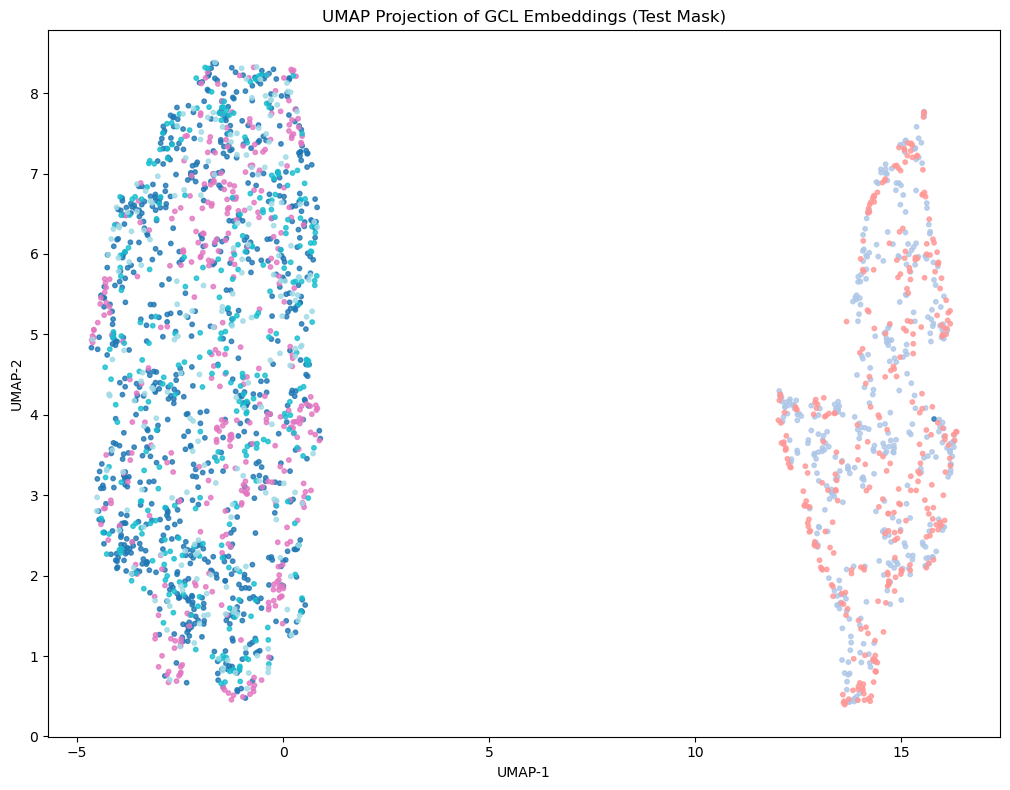

📈 嵌入可视化图已保存：/home/charles/HZU/Industrial_Software_Testing/Industrial_Software_Testing/my_CIL_V1/GCL_pre_train/KAIST_normal_model/result/time_less_class/KAIST_normal_umap.png

🔍 GCL 表征性能指标 (含解释)：
  聚类分离度（越高越好）         : 0.0067
  特征平均范数（越高代表幅度更大）    : 3.8283
  范数标准差（越低越稳定）        : 0.4889
  维度方差均匀性（越高越好）       : 0.0917

✅ 全部结果已保存到：/home/charles/HZU/Industrial_Software_Testing/Industrial_Software_Testing/my_CIL_V1/GCL_pre_train/KAIST_normal_model/result/time_less_class


In [11]:
# ================== 1️⃣ 导入路径与函数 ==================
%run ../_init_path.py

# ==============================================================
#  my_CIL_V1/pre_train/KAIST_normal_model/eval_normal_embeddings.ipynb
# ==============================================================
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
import umap
from torch_geometric.data import Data

# === 导入模型定义 ===
from models import GraphContrastiveLearner, augment_graph, summarize_graph
# 👆 请改为你的实际模型定义文件路径
# 例如: from my_CIL_V1.src.models.graph_contrastive import GraphContrastiveLearner

# ===================== 1️⃣ 参数与路径设置 =====================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
graph_path = "/home/charles/HZU/Data_processed/my_CIL_V1/KAIST/less_class/pyg_data/time/graph_withmask.pt"  # 👈 替换为你的路径
model_path = "/home/charles/HZU/Industrial_Software_Testing/Industrial_Software_Testing/my_CIL_V1/GCL_pre_train/KAIST_normal_model/model_save/time_less_class/KAIST_normal_pretrain_best.pt"  # 👈 模型路径
save_dir = "/home/charles/HZU/Industrial_Software_Testing/Industrial_Software_Testing/my_CIL_V1/GCL_pre_train/KAIST_normal_model/result/time_less_class"
os.makedirs(save_dir, exist_ok=True)

# ===================== 2️⃣ 加载图数据与模型 =====================
data = torch.load(graph_path)
data = data.to(device)

checkpoint = torch.load(model_path, map_location=device)
cfg = checkpoint["config"]

model = GraphContrastiveLearner(**cfg).to(device)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

print("✅ 模型加载完成！")

# ===================== 3️⃣ 提取嵌入 =====================
with torch.no_grad():
    h, z = model(data.x, data.edge_index)  # h=编码特征, z=投影特征

# 只保留 test_mask 下的节点
mask = data.test_mask.cpu().numpy()

embeddings = z.cpu().numpy()[mask]

# ---- 判断 y 是否存在且有效 ----
if hasattr(data, "y") and data.y is not None:
    labels = data.y.cpu().numpy()[mask]
else:
    labels = np.zeros(mask.sum(), dtype=int)
    print("⚠️ 未检测到有效的标签 data.y，将使用全零标签代替。")

print(f"🧩 嵌入维度: {embeddings.shape}")


print(f"🧩 嵌入维度: {embeddings.shape}")

# ===================== 4️⃣ UMAP 降维 =====================
reducer = umap.UMAP(
    n_neighbors=10, 
    min_dist=0.1, 
    metric='cosine', 
    random_state=42
)
emb_2d = reducer.fit_transform(embeddings)

# ===================== 5️⃣ 绘制嵌入图（优化版） =====================
plt.figure(figsize=(12,8))
if labels is not None:
    scatter = plt.scatter(
        emb_2d[:,0], emb_2d[:,1],
        c=labels, cmap='tab20', s=10, alpha=0.8
    )
    # 🔧 图例改为右侧外置，避免覆盖数据
    legend = plt.legend(
        *scatter.legend_elements(num=None),
        title="Labels",
        loc='center left',
        bbox_to_anchor=(1.02, 0.5),
        fontsize=8
    )
    plt.gca().add_artist(legend)
else:
    plt.scatter(emb_2d[:,0], emb_2d[:,1], s=10, alpha=0.8)

plt.title("UMAP Projection of GCL Embeddings (Test Mask)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.tight_layout(rect=[0, 0, 0.85, 1])  # 为图例腾出空间

fig_path = os.path.join(save_dir, "KAIST_normal_umap.png")
plt.savefig(fig_path, dpi=300)
plt.show()
print(f"📈 嵌入可视化图已保存：{fig_path}")

# ===================== 6️⃣ 计算表征性能指标 =====================
def compute_gcl_metrics(embeddings, labels):
    """
    计算与 GCL 表征质量相关的几项指标：
      - Silhouette Score（聚类分离度）→ 越高越好
      - Feature Uniformity（维度方差均匀性）→ 越高越好
      - Mean Norm（特征平均范数）→ 越高表示分布幅度更大
      - Std Norm（特征范数标准差）→ 越低越好（稳定性）
    """
    results = {}
    if labels is not None and len(np.unique(labels)) > 1:
        results["silhouette"] = float(silhouette_score(embeddings, labels))
    else:
        results["silhouette"] = None

    norms = np.linalg.norm(embeddings, axis=1)
    results["mean_norm"] = float(norms.mean())
    results["std_norm"] = float(norms.std())

    var_per_dim = np.var(embeddings, axis=0)
    results["feature_uniformity"] = float(var_per_dim.mean())

    return results

metrics = compute_gcl_metrics(embeddings, labels)

print("\n🔍 GCL 表征性能指标 (含解释)：")
desc = {
    "silhouette": "聚类分离度（越高越好）",
    "mean_norm": "特征平均范数（越高代表幅度更大）",
    "std_norm": "范数标准差（越低越稳定）",
    "feature_uniformity": "维度方差均匀性（越高越好）"
}
for k, v in metrics.items():
    if v is not None:
        print(f"  {desc[k]:<20s}: {v:.4f}")
    else:
        print(f"  {desc[k]:<20s}: N/A")

# ===================== 7️⃣ 保存结果 =====================
np.save(os.path.join(save_dir, "KAIST_normal_emb_test.npy"), embeddings)
np.save(os.path.join(save_dir, "KAIST_normal_umap_test.npy"), emb_2d)
with open(os.path.join(save_dir, "KAIST_normal_metrics.txt"), "w") as f:
    for k, v in metrics.items():
        f.write(f"{desc[k]}: {v}\n")

print(f"\n✅ 全部结果已保存到：{save_dir}")

